# Neural Network Thermometer - Ising 2D Mean Field Scale

Given a set of spin configurations, we would like to construct an empirical probability distribution in order to find the most probable temperature value of this set. 

We follow the work [Scale-invariant Feature Extraction of Neural Network and Renormalization Group Flow](https://arxiv.org/abs/1801.07172), where a neural network is trained with labeled Monte Carlo Ising configurations, defining a thermometer with temperature scale given by the training set. However, the data set here is given by mean field Ising states.

Firstly, we load the necessary libraries, including [PyTorch](https://pytorch.org/), a suitable python library for deep learning models.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split
import time

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
torch.manual_seed(12)

from MC_Ising2D_MF import IsingMC
from net import Net
T_c = 4.0

## Loading Ising data

The first step is to load the Ising data generated by Monte Carlo procedure considering the [Curie-Weiss model](https://arxiv.org/abs/1301.2141) (fully connected Ising model), instead of the usual Ising Hamiltoninan. The file `L100_Ising2D_MC_MF.pkl` was constructed considering a square lattice $L\times L$, with $L=100$. There are 1000 spins configurations for each of 29 different temperatures $ T/J = 0.5, ..., 6.0 $ and $ T/J = 3.99, 4.00, 4.01$.

In [2]:
ising_data = pd.read_pickle('data/L100_Ising2D_MC_MF.pkl')
ising_data.head()

,energy,magn,state,temp
0,-9.211033e-07,32,"[1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, ...",6.0
1,-1.151379e-06,40,"[1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, ...",6.0
2,-6.908272e-07,-24,"[0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, ...",6.0
3,-5.756892e-07,20,"[1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, ...",6.0
4,6.908293e-07,24,"[0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, ...",6.0


With the class `IsingMC` we can check some thermodynamics quantities.

Method fit will construct states to the following temperatures: 
[6.   5.78 5.56 5.34 5.12 4.9  4.68 4.46 4.24 4.02 4.01 4.   3.99 3.8
 3.58 3.36 3.14 2.92 2.7  2.48 2.26 2.04 1.82 1.6  1.38 1.16 0.94 0.72
 0.5 ]


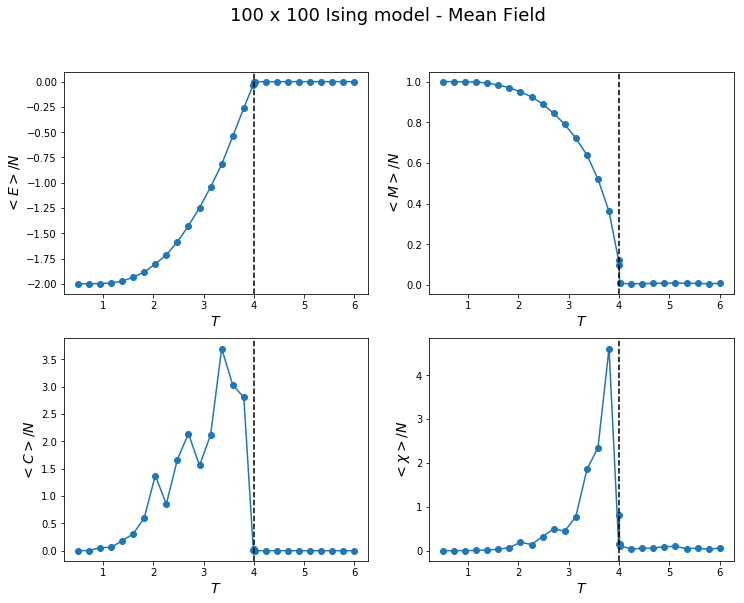

In [3]:
IsingMC(L= 100).plot_thermodynamics(spin_MC= ising_data, Tc_scaled= False)

Although the Currie-Weiss can be solved easily, the underlying assumption of an infinite-range interaction is clearly unphysical. The model correctly predicts spontaneous magnetization for $ T < T_{c}^{MF}$, but $T_{c}^{MF}$ deviates considerably from the exact value obtained by [Lars Onsager](https://en.wikipedia.org/wiki/Lars_Onsager) in [1944](https://journals.aps.org/pr/abstract/10.1103/PhysRev.65.117):

$$ \frac{T_{c}^{MF}}{J} = 2D  \;, $$
where $D$ is the system dimensionality. In our case $ D= 2$.


Since our goal is to measure temperature, the target labels for the samples `ising_data['state']` of our supervised learning must be constructed with the information given by the columns `ising_data['temp']`. 

In [4]:
data = ising_data.drop(columns= ['energy', 'magn'])

## Constructing training and test sets

Using `train_test_split` from [`sklearn`](http://scikit-learn.org/) it is easy to split the data into training and test sets. Since `train_test_split` is a random process and our data has 1000 samples for each of the 29 temperatures values, we split the data for each temperature in order to avoid the possibility of a biased split towards some temperature value.

In [5]:
train_data_ = pd.DataFrame()
test_data_ = pd.DataFrame()

for _, temp in enumerate(data['temp'].value_counts().index.tolist()):
    
    train_data_T, test_data_T = train_test_split(data[data['temp'] == temp],
                                                 test_size= 0.2,
                                                 random_state= 12)
    
    train_data_ = pd.concat([train_data_, train_data_T])
    test_data_ = pd.concat([test_data_, test_data_T])

## One-hot encoding

It is interesting to translate the targets into an [one-hot encoding](https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f) structure. 

In [6]:
train_data = pd.get_dummies(train_data_, columns=['temp'])
test_data = pd.get_dummies(test_data_, columns=['temp'])

## Creating a PyTorch dataset

Note that we use a [CUDA tensor type](https://pytorch.org/docs/stable/cuda.html), which implements GPU computation. If a GPU is not available, one should just withdraw the `cuda()` method.

In [7]:
X_train = torch.tensor(list(train_data['state']), dtype= torch.float).cuda()
y_train = torch.tensor(np.array(train_data[list(train_data.columns.values[1:])]), dtype= torch.float).cuda()

X_test = torch.tensor(list(test_data['state']), dtype= torch.float).cuda()
y_test = torch.tensor(np.array(test_data[list(test_data.columns.values[1:])]), dtype= torch.float).cuda()

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

torch.Size([23200, 10000])
torch.Size([23200, 29])
torch.Size([5800, 10000])
torch.Size([5800, 29])


In [8]:
batch_size = 100

train_loader = DataLoader(TensorDataset(X_train, y_train), 
                          batch_size= batch_size, 
                          shuffle= True)

## Training

The neural network is constructed in the class `Net`. Its code is available in the python script `net.py`.

We also have to define the network architecture, optimizer and loss function.

In [9]:
### Defining network architecture

input_size = X_train.shape[1]
out_size = y_train.shape[1]
layers_size = [input_size, 512, 256, 64]


### Initializing the class and defining the number of epochs

net = Net(layers_size, 
          out_size).cuda()     

epochs = 175

print(net)


### Defining optimizer and loss training 

optimizer = optim.SGD(net.parameters(), 
                      lr= 0.1, 
                      weight_decay= 0.0)

loss_func = nn.BCELoss()


### Dictionary to record the results 

log_dic = {
    'epoch': [],
    'loss_train' : [],
    'loss_test' : [],
}


### Training 

for epoch in range(epochs):
    
    t0 = time.time()
    
    loss_epoch = []
    
    ### Loop over mini-batches
       
    for _, (input_data, target) in enumerate(train_loader):
        
        prediction= net(input_data)
        
        loss = loss_func(prediction, target)     
        
        loss_epoch.append(loss.item())
          
        optimizer.zero_grad()   # Clear gradients for the next mini-batches
        loss.backward()         # Backpropagation, compute gradients
        optimizer.step()
               
    ### Recording some results
    log_dic['epoch'].append(epoch)
    log_dic['loss_train'].append(np.mean(loss_epoch))
    test_error_ep = loss_func(net(X_test), y_test).item()
    log_dic['loss_test'].append(test_error_ep)
    t1 = time.time()
    
    ### Training status
    print('Epoch %d, Loss_train= %.10f, Loss_test= %.10f, Time= %.4f' % (epoch, 
                                                                         np.mean(loss_epoch), 
                                                                         test_error_ep, 
                                                                         t1-t0))

Net(
  (layers): ModuleList(
    (0): Linear(in_features=10000, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=64, bias=True)
  )
  (out): Linear(in_features=64, out_features=29, bias=True)
)
Epoch 0, Loss_train= 0.1495833662, Loss_test= 0.1486545056, Time= 4.9612
Epoch 1, Loss_train= 0.1476859705, Loss_test= 0.1467013955, Time= 3.0472
Epoch 2, Loss_train= 0.1454904517, Loss_test= 0.1443105936, Time= 3.1057
Epoch 3, Loss_train= 0.1428542575, Loss_test= 0.1415376663, Time= 3.3262
Epoch 4, Loss_train= 0.1399596943, Loss_test= 0.1386386305, Time= 3.4769
Epoch 5, Loss_train= 0.1370624634, Loss_test= 0.1358290613, Time= 3.4524
Epoch 6, Loss_train= 0.1342870601, Loss_test= 0.1331204772, Time= 3.0519
Epoch 7, Loss_train= 0.1315828148, Loss_test= 0.1304462254, Time= 3.0497
Epoch 8, Loss_train= 0.1288972545, Loss_test= 0.1277863979, Time= 3.0502
Epoch 9, Loss_train= 0.1262531243, Loss_test= 0.1251849830, T

Epoch 107, Loss_train= 0.0085878140, Loss_test= 0.0084794210, Time= 3.0773
Epoch 108, Loss_train= 0.0085509961, Loss_test= 0.0106486613, Time= 3.0735
Epoch 109, Loss_train= 0.0084655025, Loss_test= 0.0092129745, Time= 3.2181
Epoch 110, Loss_train= 0.0083667442, Loss_test= 0.0084565133, Time= 3.0715
Epoch 111, Loss_train= 0.0090098830, Loss_test= 0.0082857944, Time= 3.0665
Epoch 112, Loss_train= 0.0089178389, Loss_test= 0.0085096899, Time= 3.0718
Epoch 113, Loss_train= 0.0083359047, Loss_test= 0.0087417522, Time= 3.0658
Epoch 114, Loss_train= 0.0081078669, Loss_test= 0.0093327779, Time= 3.1218
Epoch 115, Loss_train= 0.0083135486, Loss_test= 0.0082430094, Time= 3.0696
Epoch 116, Loss_train= 0.0085685966, Loss_test= 0.0096092746, Time= 3.0703
Epoch 117, Loss_train= 0.0083953462, Loss_test= 0.0080298996, Time= 3.0724
Epoch 118, Loss_train= 0.0082712860, Loss_test= 0.0080878437, Time= 3.5354
Epoch 119, Loss_train= 0.0082247689, Loss_test= 0.0078408718, Time= 3.4688
Epoch 120, Loss_train= 0.

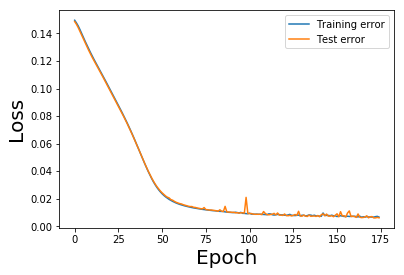

In [10]:
plt.plot(log_dic['epoch'], log_dic['loss_train'], label= 'Training error')
plt.plot(log_dic['epoch'], log_dic['loss_test'], label= 'Test error')
plt.xlabel('Epoch', fontsize= 20)
plt.ylabel('Loss', fontsize= 20)
plt.legend()
plt.show()

### Saving the trained model to a file

In [11]:
torch.save(net, 'NN_trained_models/L100_NN_Ising2D_MC_MF.pt')

## Measuring temperatures with the trained neural network

As a sanity check, we use the trained neural network to construct the empirical probability temperature distribution for each set of labeled configurations in the test dataset. If the thermometer works fine, the empirical probabilities should be centered around the reference values.

To clean the presentation, we define a suitable plot function.

In [14]:
def thermometer(data,
                T_list,
                x_min, x_max):
    
    for _, temp in enumerate(T_list):
        
           
        ising_state_temp = data[data['temp'] == temp]['state']
    
        X_ising_test = torch.tensor(list(ising_state_temp), dtype= torch.float).cuda()
    
        prediction= net(X_ising_test)
    
        x_ = np.sort(data['temp'].value_counts().index)
    
        plt.plot(x_,
                 prediction.cpu().mean(dim=0).data.numpy(),
                 marker= '.',
                 label= 'T = %.3f' % temp )
    
        plt.axvline(x= temp, linestyle= ':', linewidth= 0.5, color= 'gray')
    
        plt.xlabel('Temperature ', fontsize= 15)
        plt.ylabel('Empirical probability', fontsize= 15)

    plt.legend(loc= 'center left', bbox_to_anchor=(1, 0.5), fontsize= 'small')
    plt.xlim([x_min, x_max])
    plt.show()

Defining a list encompassing the temperature scale, we can use the function `thermometer` to plot the empirical probability temperatures.

In [15]:
T_list = test_data_['temp'].value_counts().index.tolist()
T_list.sort()

The dashed lines are the labeled temperature values.

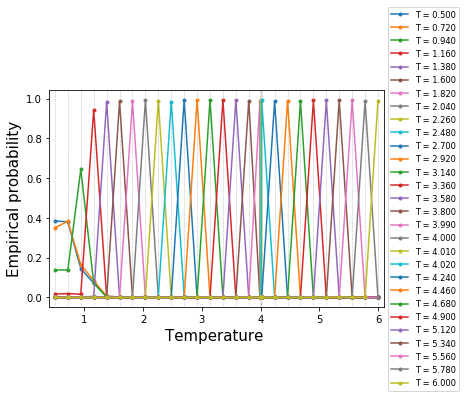

In [18]:
thermometer(test_data_, 
            T_list,
            x_min= min(T_list) - 0.1, x_max= max(T_list) + 0.1)

Since it is possible to achieve low training and test error values (probably because the dataset is much simpler), the mean field thermometer is more precise than the one trained with the usual Ising model. 

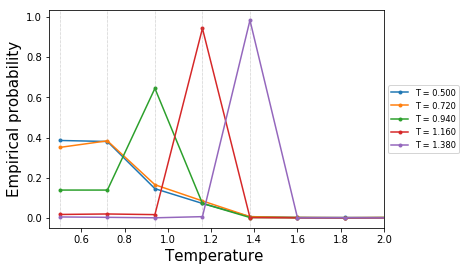

In [20]:
thermometer(test_data_, 
            T_list[:5],
            x_min= min(T_list[:5]) - 0.05, x_max= 2.0)

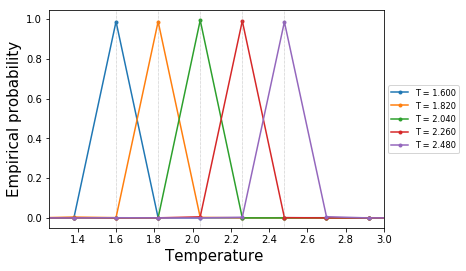

In [22]:
thermometer(test_data_, 
            T_list[5:10],
            x_min= 1.25, x_max= 3.0)

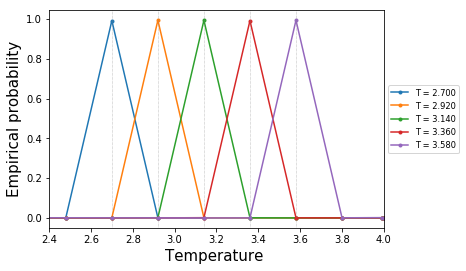

In [24]:
thermometer(test_data_, 
            T_list[10:15],
            x_min= 2.4, x_max= 4.0)

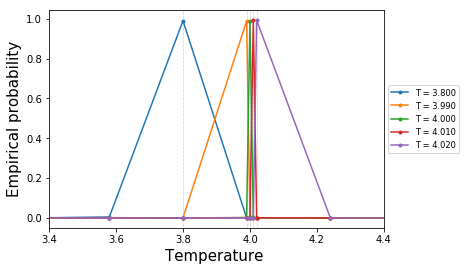

In [29]:
thermometer(test_data_, 
            T_list[15:20],
            x_min= 3.4, x_max= 4.4)

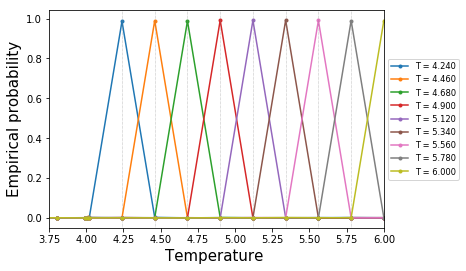

In [33]:
thermometer(test_data_, 
            T_list[20:29],
            x_min= 3.75, x_max= 6)